# Advanced Exploratory Data Analysis Cancer RNA-seq

Aims: 

* Visualize the data through PCA
* Visualize thr data through UMAP
* Visualize the association between genes and Principal Components
* Employing UMAP for feature extraction and HDBSCAN for consequently clustering the data
* Visualize the gene expression profile of the various clusters and compare them

Data: https://www.kaggle.com/murats/gene-expression-cancer-rnaseq  

UMAP: https://umap-learn.readthedocs.io/en/latest/index.html
HDBSCAN: https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import numpy as np

import pandas as pd

from sklearn.preprocessing import RobustScaler as rs
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.metrics import adjusted_mutual_info_score as admi
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegressionCV as lrcv
from sklearn.model_selection import StratifiedShuffleSplit as sss

import hdbscan

from sklearn.decomposition import PCA
from umap import UMAP

import matplotlib.pyplot as plt
import seaborn as sns

from modules.utils.data_utils import CatEncoderDecoder, top_k_variance
from modules.visualization import visualize_dim_reduction, visualize_PCA_summary
from modules.visualization import visualize_expression, visualize_expression_comp

In [3]:
sns.set(
    style='whitegrid',
    font_scale=1.5
)

In [4]:
df = pd.read_csv('data\\data.csv')
labels = pd.read_csv('data\\labels.csv', sep=';')
df = df.merge(labels, on='sample_id')

y_map = {
    'BRCA': 'Breast Cancer',
    'COAD': 'Colon Cancer',
    'KIRC': 'Kidney Renal Cancer',
    'LUAD': 'Lung Cancer',
    'PRAD': 'Prostate Cancer'
}

FEATURES_NAMES = np.array(
        list(
            df.drop(
                ['sample_id', 'Class'], 
                axis=1
            )
        )
)

In [5]:
X = df.drop(
        ['sample_id', 'Class'], 
        axis=1
).values
# we retain only the top 2000 genese with the highest variance among samples
X, FEATURES_NAMES = top_k_variance(
    X, 
    names=FEATURES_NAMES,
    k=2000
)

In [6]:
X_centered = rs().fit_transform(X)
y = df['Class'].values
y = np.array([y_map[element] for element in y])

In [7]:
labels_enc_dec = CatEncoderDecoder(
    categories=np.unique(y)
)

N_SAMPLES = X.shape[0]
N_FEATURES = len(FEATURES_NAMES)

UMAP_COMPONENTS_REDUCTION = 2
UMAP_COMPONENTS_FEATURES = 20
UMAP_EPOCHS = 2000

MIN_SAMPLES_PERC = 0.05
MIN_CLUSTER_SIZE_PERC = 0.05

## PCA

In [8]:
pca_reducer = PCA(n_components=2)
pca_reducer.fit(X_centered)
pc = pca_reducer.transform(X_centered)

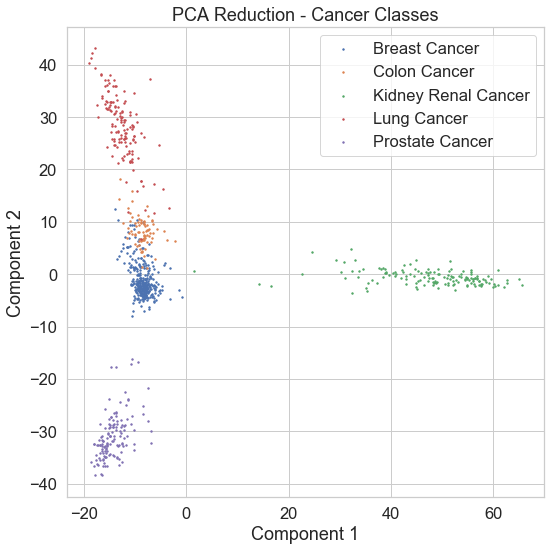

In [9]:
visualize_dim_reduction(
    reduction=pc, 
    title='PCA Reduction - Cancer Classes', 
    labels=y,
    s=2,
    figsize=(8, 8)
)

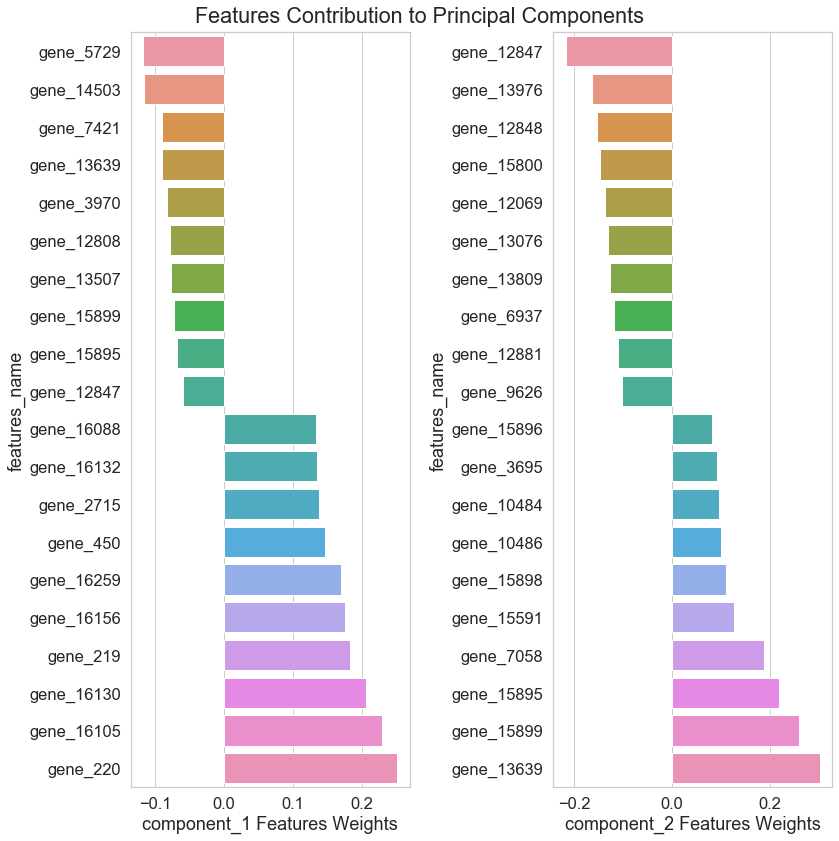

In [10]:
visualize_PCA_summary(
    pca_fitter=pca_reducer, 
    features_name=FEATURES_NAMES, 
    title='Features Contribution to Principal Components', 
    k=10,
    figsize=(12, 12)
)

## UMAP

Another possible approach is to visualize the data after a transformation able to re-produce the geometry of the 
multi dimensional space (16k genes) into a 2D map.

This new rappresentation will place samples with similar genes expression profile closer in the 2D space

In [13]:
# we grid search for the best hyperparameters
for neighbors in tqdm([5, 10 , 20, 50, 100, 200, 400]):
    
    for min_dist in tqdm([0.001, 0.01, 0.1, 0.2, 0.5, 0.9]):
        
        for metric in tqdm(['euclidean', 'cosine', 'manhattan']):
            
            manifold_reducer = UMAP(
                n_components=UMAP_COMPONENTS_REDUCTION,
                n_neighbors=neighbors, 
                n_epochs=UMAP_EPOCHS,
                metric=metric,
                min_dist=min_dist
            )
            manifold = manifold_reducer.fit_transform(X_centered)

            visualize_dim_reduction(
                reduction=manifold, 
                title=f'UMAP Reduction - Cancer Classes - {neighbors} - {min_dist} - {metric}', 
                labels=y,
                s=5,
                figsize=(8, 8),
                alpha=0.5,
                save_dir='results\\figures\\umap_tuning'
            )

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python36\lib\site-packages\umap\layouts.py", line 60:

def _optimize_layout_euclidean_single_epoch(
^

  state.func_ir.loc))


 33%|████████████████████████████                                                        | 1/3 [00:05<00:11,  5.57s/it]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_pas

 33%|████████████████████████████                                                        | 1/3 [00:05<00:10,  5.32s/it]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python36\lib\site-packages\umap\layouts.py", line 60:

def _optimize_layout_euclidean_single_epoch(
^

  state.func_ir.loc))


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:11<00:05,  5.59s/it]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parall

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:14<00:07,  7.12s/it]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python36\lib\site-packages\umap\layouts.py", line 60:

def _optimize_layout_euclidean_single_epoch(
^

  state.func_ir.loc))


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.40s/it]

 17%|██████████████                                                                      | 1/6 [00:22<01:50, 22.19s/it]

  0%|                                                                                    

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python36\lib\site-packages\umap\layouts.py", line 60:

def _optimize_layout_euclidean_single_epoch(
^

  state.func_ir.loc))


 33%|████████████████████████████                                                        | 1/3 [00:06<00:13,  6.96s/it]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parall

 33%|████████████████████████████                                                        | 1/3 [00:08<00:16,  8.44s/it]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python36\lib\site-packages\umap\layouts.py", line 60:

def _optimize_layout_euclidean_single_epoch(
^

  state.func_ir.loc))


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:18<00:08,  8.85s/it]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parall



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:28<00:00,  9.42s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [02:20<00:28, 28.14s/it]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python36\lib\site-packages\umap\layouts.py", line 60:

def _optimize_layout_euclidean_single_epoch(
^

  state.func_ir.loc))


 33%|████████████████████████████                                                      



 33%|████████████████████████████                                                        | 1/3 [00:11<00:23, 11.99s/it]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python36\lib\site-packages\umap\layouts.py", line 60:

def _optimize_layout_euclidean_single_epoch(
^

  state.func_ir.loc))


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:23<00:11, 11.80s/it]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for para



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:34<00:00, 11.59s/it]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python36\lib\site-packages\umap\layouts.py", line 60:

def _optimize_layout_euclidean_single_epoch(
^

  state.func_ir.loc))


 33%|████████████████████████████                                                      



 33%|████████████████████████████                                                        | 1/3 [00:12<00:25, 12.76s/it]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python36\lib\site-packages\umap\layouts.py", line 60:

def _optimize_layout_euclidean_single_epoch(
^

  state.func_ir.loc))


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:26<00:12, 12.91s/it]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for para

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:27<00:13, 13.95s/it]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python36\lib\site-packages\umap\layouts.py", line 60:

def _optimize_layout_euclidean_single_epoch(
^

  state.func_ir.loc))


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:41<00:00, 13.93s/it]

 17%|██████████████                                                                      | 1/6 [00:41<03:28, 41.79s/it]

  0%|                                                                                    

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python36\lib\site-packages\umap\layouts.py", line 60:

def _optimize_layout_euclidean_single_epoch(
^

  state.func_ir.loc))


 33%|████████████████████████████                                                        | 1/3 [00:13<00:27, 13.58s/it]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parall

 33%|████████████████████████████                                                        | 1/3 [00:15<00:31, 15.54s/it]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python36\lib\site-packages\umap\layouts.py", line 60:

def _optimize_layout_euclidean_single_epoch(
^

  state.func_ir.loc))


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:31<00:15, 15.70s/it]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parall



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:47<00:00, 15.98s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [03:59<00:47, 47.92s/it]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python36\lib\site-packages\umap\layouts.py", line 60:

def _optimize_layout_euclidean_single_epoch(
^

  state.func_ir.loc))


 33%|████████████████████████████                                                      

c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python36\lib\site-packages\umap\layouts.py", line 60:

def _optimize_layout_euclidean_single_epoch(
^

  state.func_ir.loc))


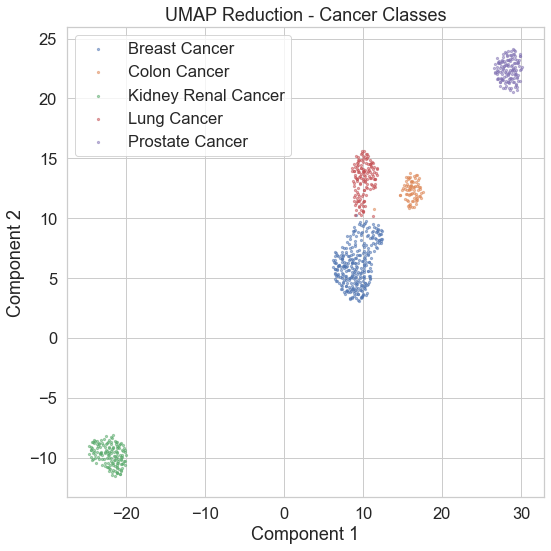

In [14]:
manifold_reducer = UMAP(
    n_components=UMAP_COMPONENTS_REDUCTION,
    n_neighbors=200, 
    n_epochs=UMAP_EPOCHS,
    metric='cosine',
    min_dist=0.9
)
manifold = manifold_reducer.fit_transform(X_centered)

visualize_dim_reduction(
    reduction=manifold, 
    title='UMAP Reduction - Cancer Classes', 
    labels=y,
    s=5,
    figsize=(8, 8),
    alpha=0.5
)

## UMAP + Density Based Clustering

We can also use UMAP for perfroming dimensionality reduction.

In [23]:
features_reducer = UMAP(
    n_components=UMAP_COMPONENTS_FEATURES, 
    n_neighbors=100, 
    n_epochs=UMAP_EPOCHS,
    metric='cosine',
    min_dist=0.1
)
cluster_features = features_reducer.fit_transform(X_centered)

c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python36\lib\site-packages\umap\layouts.py", line 60:

def _optimize_layout_euclidean_single_epoch(
^

  state.func_ir.loc))


In [24]:
cluster_labels = hdbscan.HDBSCAN(
    min_samples=int(X.shape[0] * MIN_SAMPLES_PERC),
    min_cluster_size=int(X.shape[0] * MIN_CLUSTER_SIZE_PERC),
).fit_predict(cluster_features)

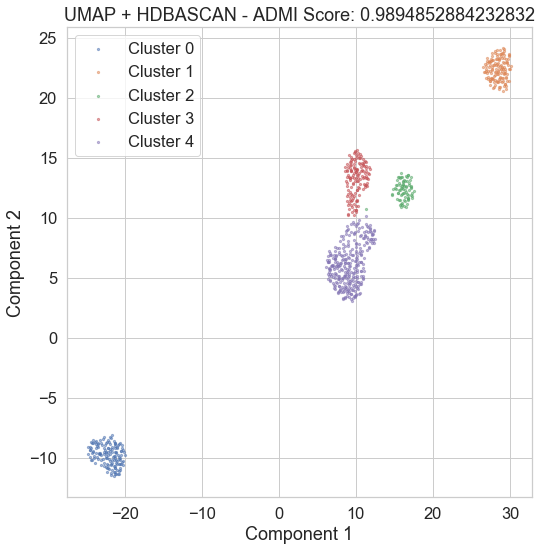

In [25]:
score = admi(
    labels_enc_dec.encode(y), 
    cluster_labels
)
visualize_dim_reduction(
    reduction=manifold, 
    title=f'UMAP + HDBASCAN - ADMI Score: {score}', 
    labels=np.array([f'Cluster {label}' for label in cluster_labels]),
    s=5,
    alpha=0.5,
    figsize=(8, 8)
)

### Exploration of Clusters Characteristics 

In [26]:
clusters_expressions_cent = {}
for label in np.unique(cluster_labels):
    
    indices = np.argwhere(cluster_labels == label).flatten()
    clusters_expressions_cent[label] = X_centered[indices, :]

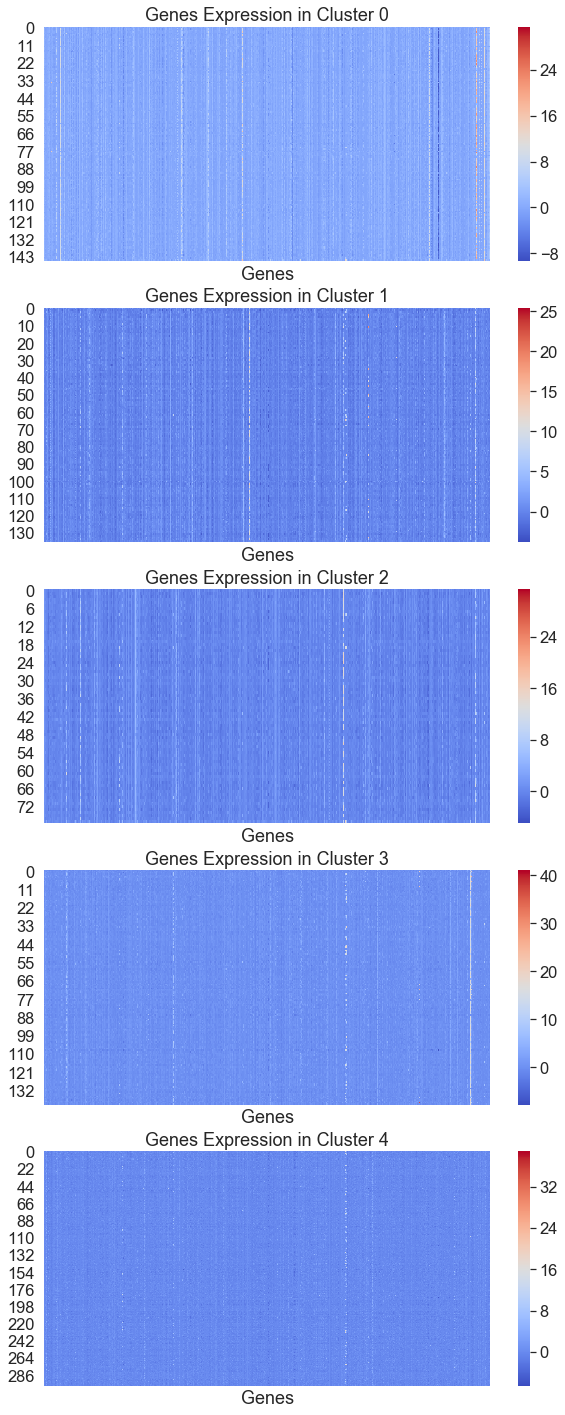

In [27]:
visualize_expression(
    clusters_expressions_cent,
    figsize=(10, 25), 
    median=False
)

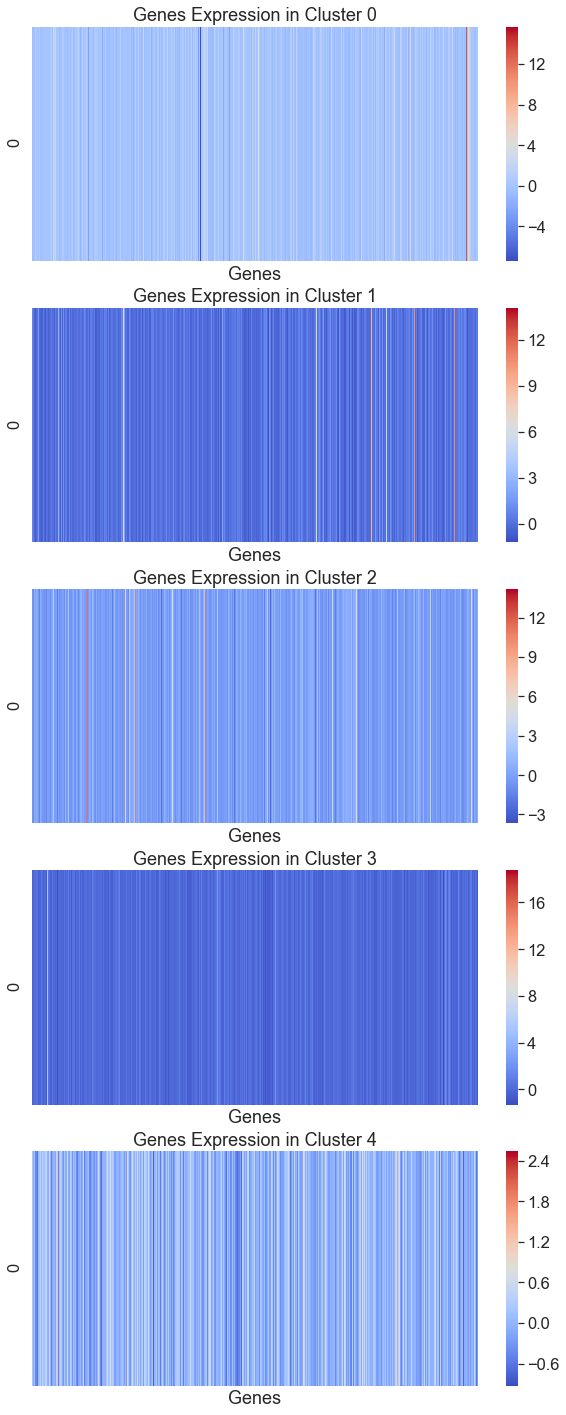

In [29]:
visualize_expression(
    clusters_expressions_cent, 
    figsize=(10, 25), 
    median=True
)

## Gene Selection

In [ ]:
for tr_ind, ts_ind in sss(n_splits=1, test_size=0.3).split(X_centered, cluster_labels):
    
    X_tr, X_ts = X_centered[tr_ind], X_centered[ts_ind]
    y_tr, y_ts = cluster_labels[tr_ind], cluster_labels[ts_ind]
    
model = lrcv( 
    Cs=50,
    cv=5,
    max_iter=500,
    penalty='l1',
    n_jobs=-1,
    verbose=True,
    solver='saga'
)
model.fit(
    X_tr,
    y_tr
)
coefficients = model.coef_

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds

convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 1 secondsconvergence after 1 epochs took 1 seconds
convergence after 1 epochs took 1 seconds

convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 

c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



max_iter reached after 32 seconds


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 342 epochs took 22 seconds
max_iter reached after 32 seconds


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 31 seconds
max_iter reached after 31 seconds


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 268 epochs took 16 seconds
max_iter reached after 31 seconds


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 237 epochs took 14 seconds
max_iter reached after 30 seconds


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 30 seconds


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 31 seconds


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 225 epochs took 14 seconds
max_iter reached after 31 seconds


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 262 epochs took 17 seconds
max_iter reached after 31 seconds


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 31 seconds
max_iter reached after 31 seconds


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 275 epochs took 17 seconds
max_iter reached after 32 seconds


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 250 epochs took 15 seconds
convergence after 363 epochs took 23 seconds
max_iter reached after 32 seconds


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 311 epochs took 19 seconds
max_iter reached after 31 seconds


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 194 epochs took 12 seconds
convergence after 278 epochs took 16 seconds
convergence after 134 epochs took 8 seconds
convergence after 382 epochs took 23 seconds
convergence after 95 epochs took 6 seconds
convergence after 324 epochs took 19 seconds
convergence after 60 epochs took 4 seconds
convergence after 228 epochs took 14 seconds
convergence after 35 epochs took 2 seconds
convergence after 34 epochs took 2 seconds
convergence after 29 epochs took 3 seconds
convergence after 16 epochs took 1 seconds
convergence after 20 epochs took 2 seconds
convergence after 8 epochs took 0 seconds
convergence after 5 epochs took 1 seconds
max_iter reached after 30 seconds


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 5 epochs took 0 seconds
convergence after 3 epochs took 1 seconds
convergence after 4 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 188 epochs took 11 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 0 seconds
convergence after 312 epochs took 19 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 275 epochs took 17 seconds
convergence after 135 epochs took 8 seconds
convergence after 92 epochs took 5 seconds
convergence after 212 epochs took 12 seconds
convergence after 304 epochs took 17 seconds
convergence after 282 epochs took 16 seconds
convergence after 70 epochs took 4 seconds
convergence after 65 epochs took 4 seconds
convergence

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.9min remaining: 10.4min


convergence after 23 epochs took 1 seconds
convergence after 192 epochs took 11 seconds
convergence after 17 epochs took 1 seconds
convergence after 14 epochs took 1 seconds
convergence after 163 epochs took 8 seconds
convergence after 8 epochs took 1 seconds
convergence after 9 epochs took 1 seconds
convergence after 10 epochs took 1 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 6 epochs took 1 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 1 seconds
convergence after 106 epochs took 6 seconds
convergence after 160 epochs took 8 seconds
convergence after 63 

In [ ]:
norm = plt.Normalize(-3, 3)
cmap = plt.get_cmap('coolwarm')
for cluster_label in np.unique(cluster_labels):
    
    fig, axs = plt.subplots(
        2, 
        1, 
        figsize=(18, 8),
        sharex=True
    )
    
    cluster_coeff = coefficients[cluster_label, :]
    cluster_coeff_ind = cluster_coeff > 0
    cluster_coeff = cluster_coeff[cluster_coeff_ind]
    
    cluster_expression_data = clusters_expressions_cent[cluster_label]
    cluster_expression_data = cluster_expression_data[:, cluster_coeff_ind]
    
    cluster_features_names = FEATURES_NAMES[cluster_coeff_ind]
    
    importance_df = pd.DataFrame(columns=['Gene', 'Importance'])
    importance_df['Gene'] = cluster_features_names
    importance_df['Importance'] = cluster_coeff
    importance_df = importance_df.sort_values('Importance')
    if len(importance_df) > 20:
        importance_df = importance_df[:21]
        
    expression_df = pd.DataFrame(
        cluster_expression_data, 
        columns=cluster_features_names
    )
    expression_df = pd.melt(
        expression_df,
        var_name='Gene',
        value_name='Expression'
    )
    
    data = expression_df.merge(importance_df)
    data = data.sort_values(
        ['Importance', 'Expression'], 
        ascending=False
    )
    
    sns.barplot(
        y='Importance',
        x='Gene',
        data=data,
        ax=axs[0],
        palette='Reds_r'
    )
    axs[0].set_title(f'Cluster {cluster_label} Genes Importance')
    
    cmap_values = data.groupby('Gene').mean().reset_index()
    cmap_values = cmap_values.sort_values('Importance', ascending=False)['Expression'].values
    sns.barplot(
        y='Expression',
        x='Gene',
        ax=axs[1],
        data=data,
        palette=cmap(norm(cmap_values))
    )
    axs[1].set_title(f'Cluster {cluster_label} Genes Expression')
    axs[1].set_xticklabels(labels=data['Gene'].unique(), rotation=90)

    plt.tight_layout()
    plt.show()

## Comparative Analysis

In [ ]:
clusters_expressions_comp = {}
non_zero_coeff = np.unique(np.argwhere(coefficients != 0)[:, 1])
for cluster, expression in clusters_expressions_cent.items():
    
    clusters_expressions_comp[cluster] = expression[:, non_zero_coeff]

In [ ]:
visualize_expression_comp(
    clusters_expressions_comp, 
    figsize=(10, 40), 
    s=1
)

## Sub Clusters

In [ ]:
fig, axs = plt.subplots(
    1, 
    len(np.unique(cluster_labels)), 
    figsize=(20, 5)
)

for cluster_label, ax in zip(np.unique(cluster_labels), axs):
    
    cluster_ind = np.argwhere(cluster_labels == cluster_label).flatten()
    sub_cluster_manifold = manifold[cluster_ind, :]
    
    sub_cluster_labels = hdbscan.HDBSCAN(
    min_samples=int(sub_cluster_manifold.shape[0] * 0.05),
    min_cluster_size=int(sub_cluster_manifold.shape[0] * 0.1)
    ).fit_predict(cluster_features[cluster_ind, :])
    
    for sub_cluster_label in np.unique(sub_cluster_labels):
        
        sub_cluster_ind = np.argwhere(sub_cluster_labels == sub_cluster_label).flatten()
        if sub_cluster_label < 0:
            alpha = 0.09
            label = 'Noise'
        else:
            alpha = 1
            label = f'Sub Cluster {sub_cluster_label}'
        ax.scatter(
            sub_cluster_manifold[sub_cluster_ind, 0], 
            sub_cluster_manifold[sub_cluster_ind, 1], 
            s=10,
            alpha=alpha,
            label=label
        )
        ax.set_title(f'Cluster {cluster_label}')
        
    ax.legend(loc='lower center', bbox_to_anchor=(.5, -0.5))

plt.tight_layout()
plt.show()